<a href="https://colab.research.google.com/github/johnfcchan/crackdatescience/blob/master/Prediction_on_Kaggle_AirBnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Import Libs

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

#2 Load Datasets

In [63]:
!pwd

/content


In [64]:
data_dir = 'BayAreaAirBNB'
fnames = ['Airbnb_Listings.csv', 'neighbourhoods.csv', 'reviews.csv']
fname = fnames[0]
dfs = []
for fname in fnames:
    dfs.append(pd.read_csv(os.path.join("/content/drive/My Drive/Colab Notebooks/datasets/", data_dir, fname), index_col=0))
dfs[0].head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4952,https://www.airbnb.com/rooms/4952,20200530151957,2020-05-30,Butterfly Inn - Graceful Living !,"Lovely garden setting in a serene and art-filled home. Private bedroom, the rest of the house offers mini kitchen with small microwave and fridge on the same level. Large equipped kitchen upstairs. There are 2 full Bathrooms (1 upstairs) shared between 4 guest rooms. The price is well below market price for the location and ambience. Room is in the basement. Best for someone comfortable with ...","Very comfortable Queen bed and small desk in beautiful home with plenty of closet space. ""A home away from home"" - a very special place to visit that you will remember for a long time, and want to come back to. Stanford Affiliation preferred and needs to be confirmed - we warmly welcome visiting family, faculty, researchers or students, and we especially welcome international visitors. Note: ...","Lovely garden setting in a serene and art-filled home. Private bedroom, the rest of the house offers mini kitchen with small microwave and fridge on the same level. Large equipped kitchen upstairs. There are 2 full Bathrooms (1 upstairs) shared between 4 guest rooms. The price is well below market price for the location and ambience. Room is in the basement. Best for someone comfortable with ...",none,"Located in Professorville, Palo Alto, one of the oldest sections of Palo Alto. The garage where Hewlett and Packard started their business is less than 5 minutes walk away along Addision Streeet and is on the National Register of Historic Buildings as ""the Birthplace of Silicon Valley."" 6 blocks to Downtown Palo Alto, and 5 minutes walk to El Camino, Town and Country Village - Whole Foods Mar...","Housekeeping every Monday, leave your door open if you want the sheets and towels changed and the floor vacuumed. The garden is calm, serene and has a fountain and tea pavilion with flowers, fruit and fresh herbs for cooking, just down from the back porch. Mandarin and Australian spoken. Some German, a little Cantonese.","Walking distance to Stanford University (30 minutes to the Main Quad) , and the Stanford Shopping Center (15 minutes). free Stanford Shuttle(10 minutes) and the Palo Alto train station (10 minutes) with service to San Francisco, San Jose and the SFO (change to BART and Milbrae), The train station is co-located is the main bus terminal and the Stanford Shuttle at University Avenue near El Cam...","Kitchen, la

In [65]:
dfs[1].head()

,neighbourhood
neighbourhood_group,
NaN,Campbell
NaN,Cupertino
NaN,Gilroy
NaN,Los Altos
NaN,Los Altos Hills


In [66]:
dfs[2].head()

,date
listing_id,
4952,2009-08-02
4952,2009-09-04
4952,2009-10-16
4952,2009-12-10
4952,2010-06-08


#3 EDA - Drop & Impute

##3.1 df-Listing

### 3.1.0 Transform price, weekly_price, & monthly_price

In [25]:
from re import sub
from decimal import Decimal

money = '$6,150,593.22'
value = Decimal(sub(r'[^\d.]', '', money))

In [26]:
# dfs[0].weekly_price.notnull()

In [67]:
def parse_price(p): 
    # print(type(p))
    # if p:
    # if not np.isnan(p):
    # p = str(p)
    if not pd.isna(p):
        # return float(p.split('$')[-1].replace(',', ''))
        return Decimal(sub(r'[^\d.]', '', p))
        # return float(sub(r'[^\d.]', '', p))
# dfs[0].monthly_price.map(parse_price)
# dfs[0].monthly_price.map(parse_price).astype(np.float)
dfs[0]['price'] = dfs[0].price.map(parse_price)
dfs[0]['weekly_price'] = dfs[0].weekly_price.map(parse_price)
dfs[0]['monthly_price'] = dfs[0].monthly_price.map(parse_price)
dfs[0] = dfs[0].astype({'price': np.float, 'weekly_price': np.float, 'monthly_price': np.float})

In [68]:
dfs[0].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7221 entries, 4952 to 43591340
Data columns (total 105 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   listing_url                                   object 
 1   scrape_id                                     int64  
 2   last_scraped                                  object 
 3   name                                          object 
 4   summary                                       object 
 5   space                                         object 
 6   description                                   object 
 7   experiences_offered                           object 
 8   neighborhood_overview                         object 
 9   notes                                         object 
 10  transit                                       object 
 11  access                                        object 
 12  interaction                                   object 


### 3.1.1Regular Drop

In [69]:
dfs[0].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7221 entries, 4952 to 43591340
Data columns (total 105 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   7221 non-null   object 
 1   scrape_id                                     7221 non-null   int64  
 2   last_scraped                                  7221 non-null   object 
 3   name                                          7220 non-null   object 
 4   summary                                       6922 non-null   object 
 5   space                                         5514 non-null   object 
 6   description                                   6983 non-null   object 
 7   experiences_offered                           7221 non-null   object 
 8   neighborhood_overview                         4544 non-null   object 
 9   notes                                         3692 non-

In [70]:
dfs[0].columns[:30]

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url'],
      dtype='object')

In [71]:
drops_NLP = ['listing_url', 'scrape_id', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url',
       'host_location', 'host_about',
       'host_response_time', 
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 
       'host_verifications']
""" 
KEEP 
last_scraped, host_id, 'host_response_rate', 'host_acceptance_rate'
"""
drops_all_NA = ['thumbnail_url', 'medium_url', 'xl_picture_url', 'neighbourhood_group_cleansed', 'license']

dfs_0_dropped = dfs[0].drop(list(set(drops_NLP + drops_all_NA)), axis=1)
dfs_0_dropped.head(5)

,last_scraped,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4952,2020-05-30,7054,Mei Lin,2009-01-24,100%,98%,Palo Alto,5.0,5.0,t,f,"Palo Alto, CA, United States",Palo Alto,Palo Alto,Palo Alto,CA,94301,"South Bay, CA","Palo Alto, CA",US,United States,37.43972,-122.15672,t,Villa,Private room,2,2.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,Washer,Dryer,""Smoke alarm"",""Carbon monoxide alarm"",""First aid kit"",""Safety card"",""Fire extinguisher"",Essentials,Shampoo,""Lock on bedroom door"",Hangers,""Hair dryer"",Iron,""Laptop-friendly workspace"",""translation missing: en.hosting_amenity_49"",""translation missing: en.hosting_amenity_50"",""Private entrance"",""Hot water"",""Bed linens"",""Extra pillows and b...",NaN,90.0,440.0,1428.0,$0.00,$35.00,1,$45.00,2,365,2,2,365,365,2.0,365.0,2 months ago,t,0,0,0,0,2020-05-30,75,0,2009-08-02,2019-01-12,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,"{""PALO ALTO""}",f,f,moderate,f,f,5,0,5,0,0.57
11464,2020-05-31,42458,Emey,2009-09-30,100%,90%,Santa Clara,13.0,13.0,t,f,"Santa Clara, CA, United States",Santa Clara,Santa Clara,Santa Clara,CA,95051,"South Bay, CA","Santa Clara, CA",US,United States,37.34342,-121.98829,t,Apartment,Entire home/apt,1,1.0,NaN,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning"",Pool,Kitchen,""Free parking on premises"",""Pets allowed"",""Pets live on this property"",Dog(s),Cat(s),""Free street parking"",Heating,Washer,Dryer,""Smoke alarm"",""Carbon monoxide alarm"",""Fire extinguisher"",Hangers,""Hair dryer"",Iron,""Laptop-friendly workspace"",""Self check-in"",""Building staff"",""Hot water"",Microwave,""Coffee maker"",Refrigerator,""Dishes and ...",325.0,85.0,NaN,2100.0,$700.00,$250.00,1,$10.00,14,365,14,14,365,365,14.0,365.0,5 months ago,t,30,60,90,179,2020-05-31,6,1,2014-06-15,2019-10-11,87.0,10.0,10.0,10.0,9.0,9.0,9.0,f,"{""SANTA CLARA""}",f,f,moderate,f,t,12,12,0,0,0.08
17884,2020-05-31,69023,Janet,2010-01-08,100%,50%,Palo Alto,2.0,2.0,t,t,"Mountain View, CA, United States",Mountain View,Mountain View,Mountain View,CA,94041,"South Bay, CA","Mountain View, CA",US,United States,37.38612,-122.07357,t,Guest suite,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning"",""Free parking on premises"",""Pets live on this property"",Dog(s),Cat(s),""Free street parking"",Heating,Washer,Dryer,""Smoke alarm"",""Carbon monoxide alarm"",Essentials,Shampoo,""Lock on bedroom door"",Hangers,""Hair dryer"",Iron,""Laptop-friendly workspace"",""Self check-in"",Keypad,""Hot water"",Microwave,Refrigerator,""Dishes and silverware"",""Luggage dro

In [72]:
dfs_0_dropped.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7221 entries, 4952 to 43591340
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   last_scraped                                  7221 non-null   object 
 1   host_id                                       7221 non-null   int64  
 2   host_name                                     7220 non-null   object 
 3   host_since                                    7220 non-null   object 
 4   host_response_rate                            5414 non-null   object 
 5   host_acceptance_rate                          6507 non-null   object 
 6   host_neighbourhood                            6040 non-null   object 
 7   host_listings_count                           7220 non-null   float64
 8   host_total_listings_count                     7220 non-null   float64
 9   host_has_profile_pic                          7220 non-n

In [73]:
df_imputation = dfs_0_dropped.copy(deep=True)

###3.1.2 Imputation

In [74]:
## 設定SimpleImputer
""" Numerical """
## 缺失值以均值填充
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
## 缺失值以中位數填充
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
## 缺失值以眾数填充
imp_most_frequent = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
## 缺失值以自定義的值填充
imp_constant_fill_w_0 = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
imp_constant_fill_w_1 = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 1)
# imp_constant_fill_w_EMPTY = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 'EMPTY')
""" Object """
imp_constant_fill_w_missingValue = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 'MISSING')

In [75]:
for col in df_imputation.columns:
    if df_imputation[col].isnull().values.sum() > 0:
        if df_imputation[col].dtype != object:
            # print(col, 'nu')
            # df_imputation[[col]] = imp_constant_fill_w_0.fit_transform(df_imputation[[col]])
            df_imputation[[col]] = imp_mean.fit_transform(df_imputation[[col]])
        else:
            # df_imputation[[col]] = imp_most_frequent.fit_transform(df_imputation[[col]])
            df_imputation[[col]] = imp_constant_fill_w_missingValue.fit_transform(df_imputation[[col]])

In [76]:
df_imputations = [None] * 3
df_imputations[0] = df_imputation

<!-- ###3.1.4 Imbalance -->

##3.2 df-Reviews

In [77]:
dfs[1]

,neighbourhood
neighbourhood_group,
NaN,Campbell
NaN,Cupertino
NaN,Gilroy
NaN,Los Altos
NaN,Los Altos Hills
NaN,Los Gatos
NaN,Milpitas
NaN,Monte Sereno
NaN,Morgan Hill


In [78]:
dfs[1].reset_index(inplace=True)

In [79]:
df_imputation_1 = dfs[1].drop('neighbourhood_group', axis=1)
# df_imputation_1
df_imputations[1] = df_imputation_1

##3.3 df-Neighbourhoods

In [80]:
dfs[2]

,date
listing_id,
4952,2009-08-02
4952,2009-09-04
4952,2009-10-16
4952,2009-12-10
4952,2010-06-08
...,...
43557408,2020-06-08
43560334,2020-06-04
43624287,2020-06-04


In [81]:
df_imputation_2 = dfs[2].reset_index()
df_imputations[2] = df_imputation_2

#4 Plotting

##4.1 df-Listing

##4.1.1 Cor Heatmaps

w/o Imputation

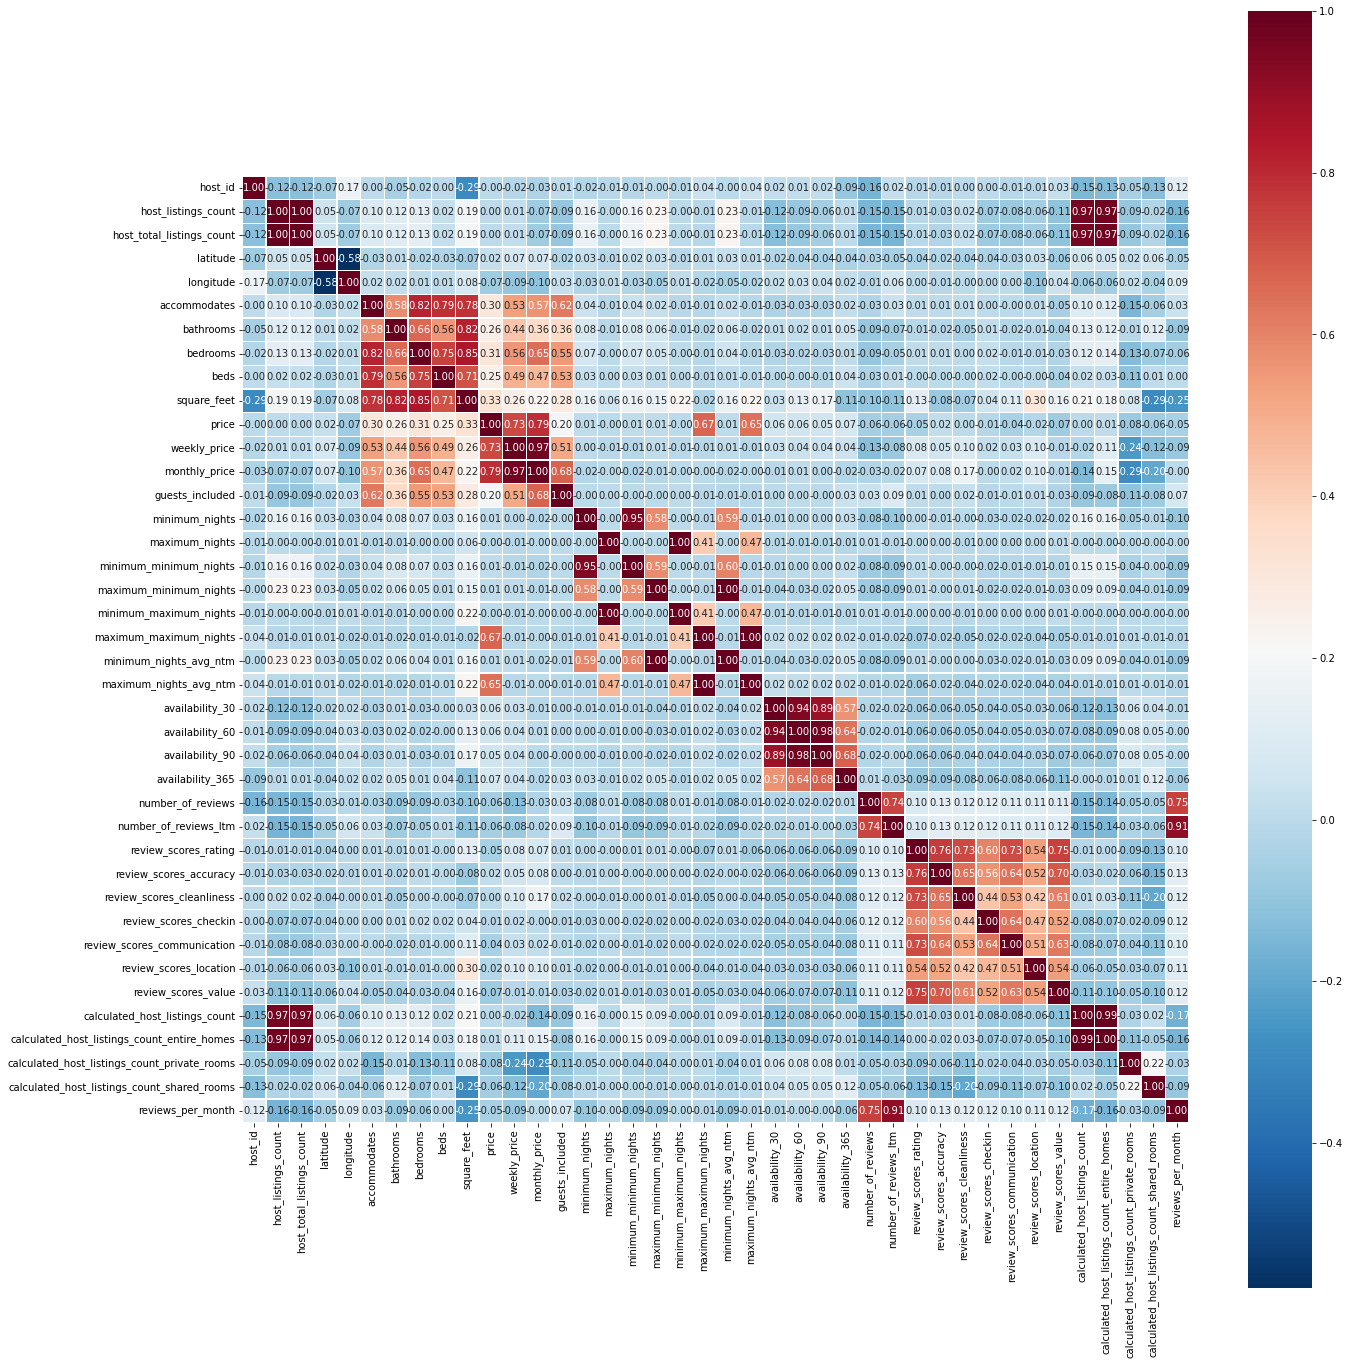

In [85]:
df = dfs_0_dropped[dfs_0_dropped.columns.to_list()[:]]
df_corr = df._get_numeric_data().astype(float).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(df_corr,
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

#### w/ Imputation

In [82]:
df_imputations[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7221 entries, 4952 to 43591340
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   last_scraped                                  7221 non-null   object 
 1   host_id                                       7221 non-null   int64  
 2   host_name                                     7221 non-null   object 
 3   host_since                                    7221 non-null   object 
 4   host_response_rate                            7221 non-null   object 
 5   host_acceptance_rate                          7221 non-null   object 
 6   host_neighbourhood                            7221 non-null   object 
 7   host_listings_count                           7221 non-null   float64
 8   host_total_listings_count                     7221 non-null   float64
 9   host_has_profile_pic                          7221 non-n

In [83]:
df = df_imputations[0][df_imputations[0].columns.to_list()[:]]
df_corr = df._get_numeric_data().astype(float).corr()

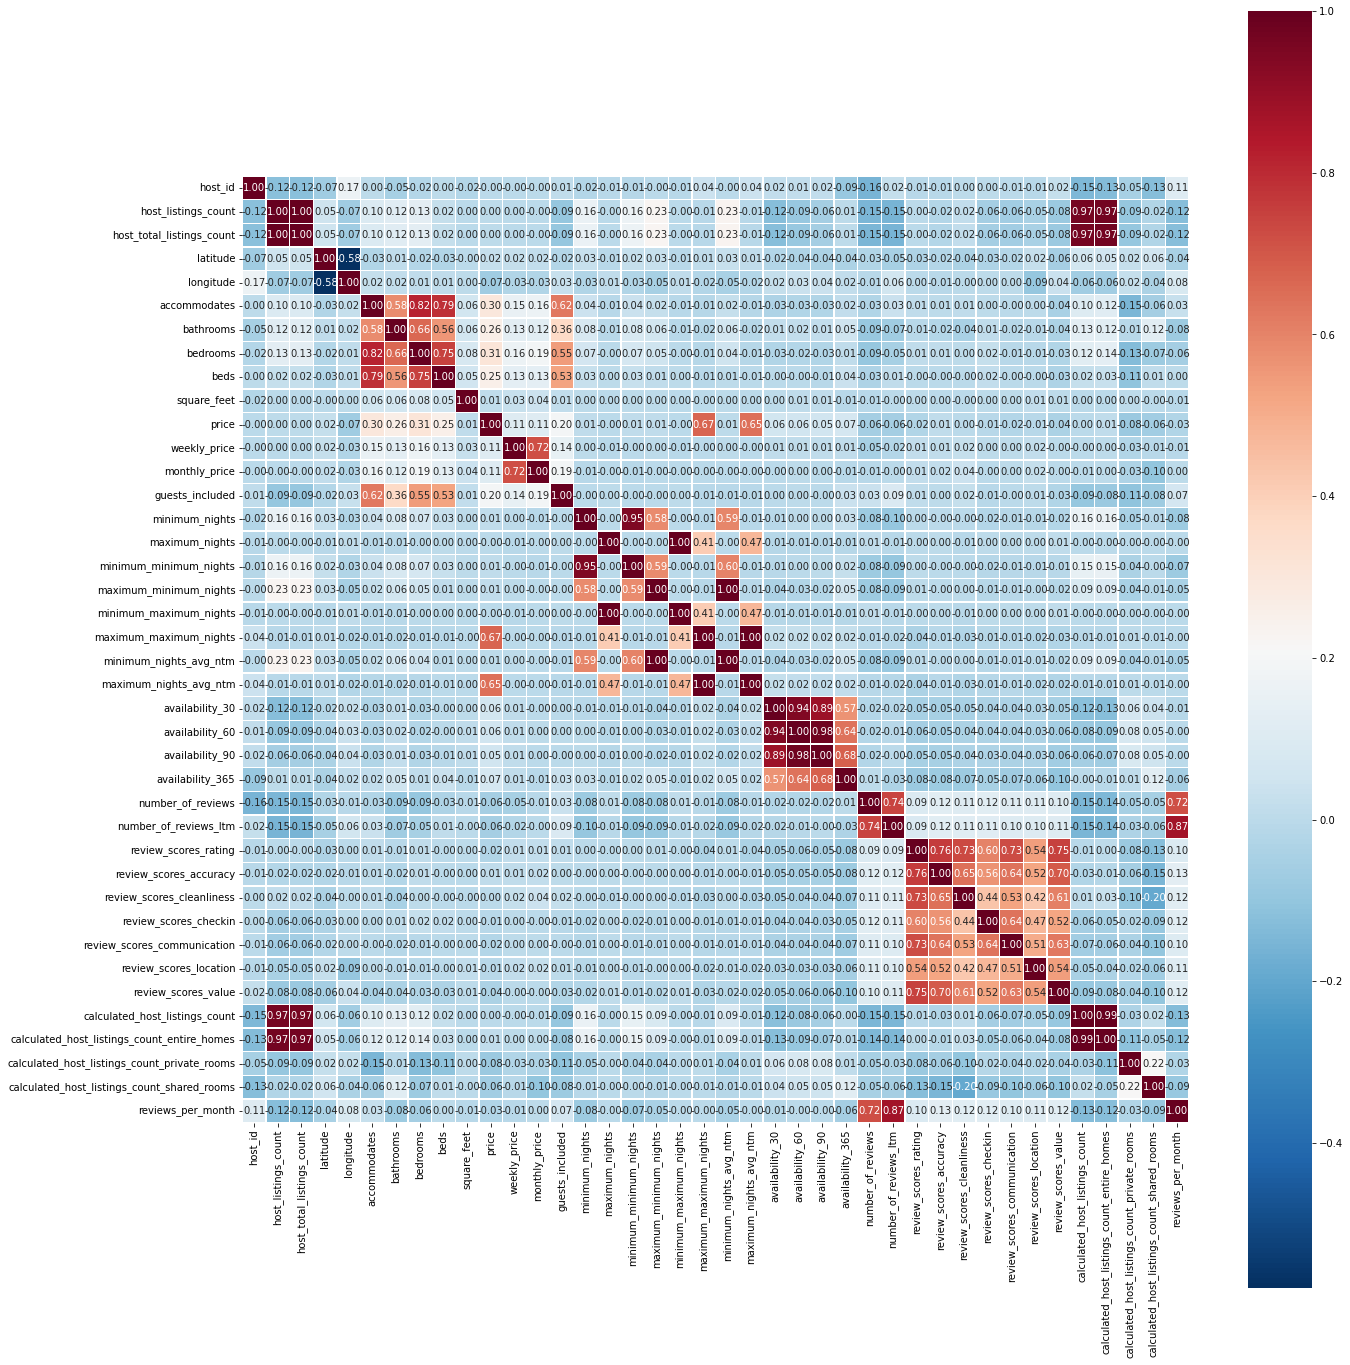

In [84]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_corr,
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

###4.1.2 Xis value_counts() (already on kaggle)

#### w/o imputation

<Figure size 2160x2160 with 0 Axes>

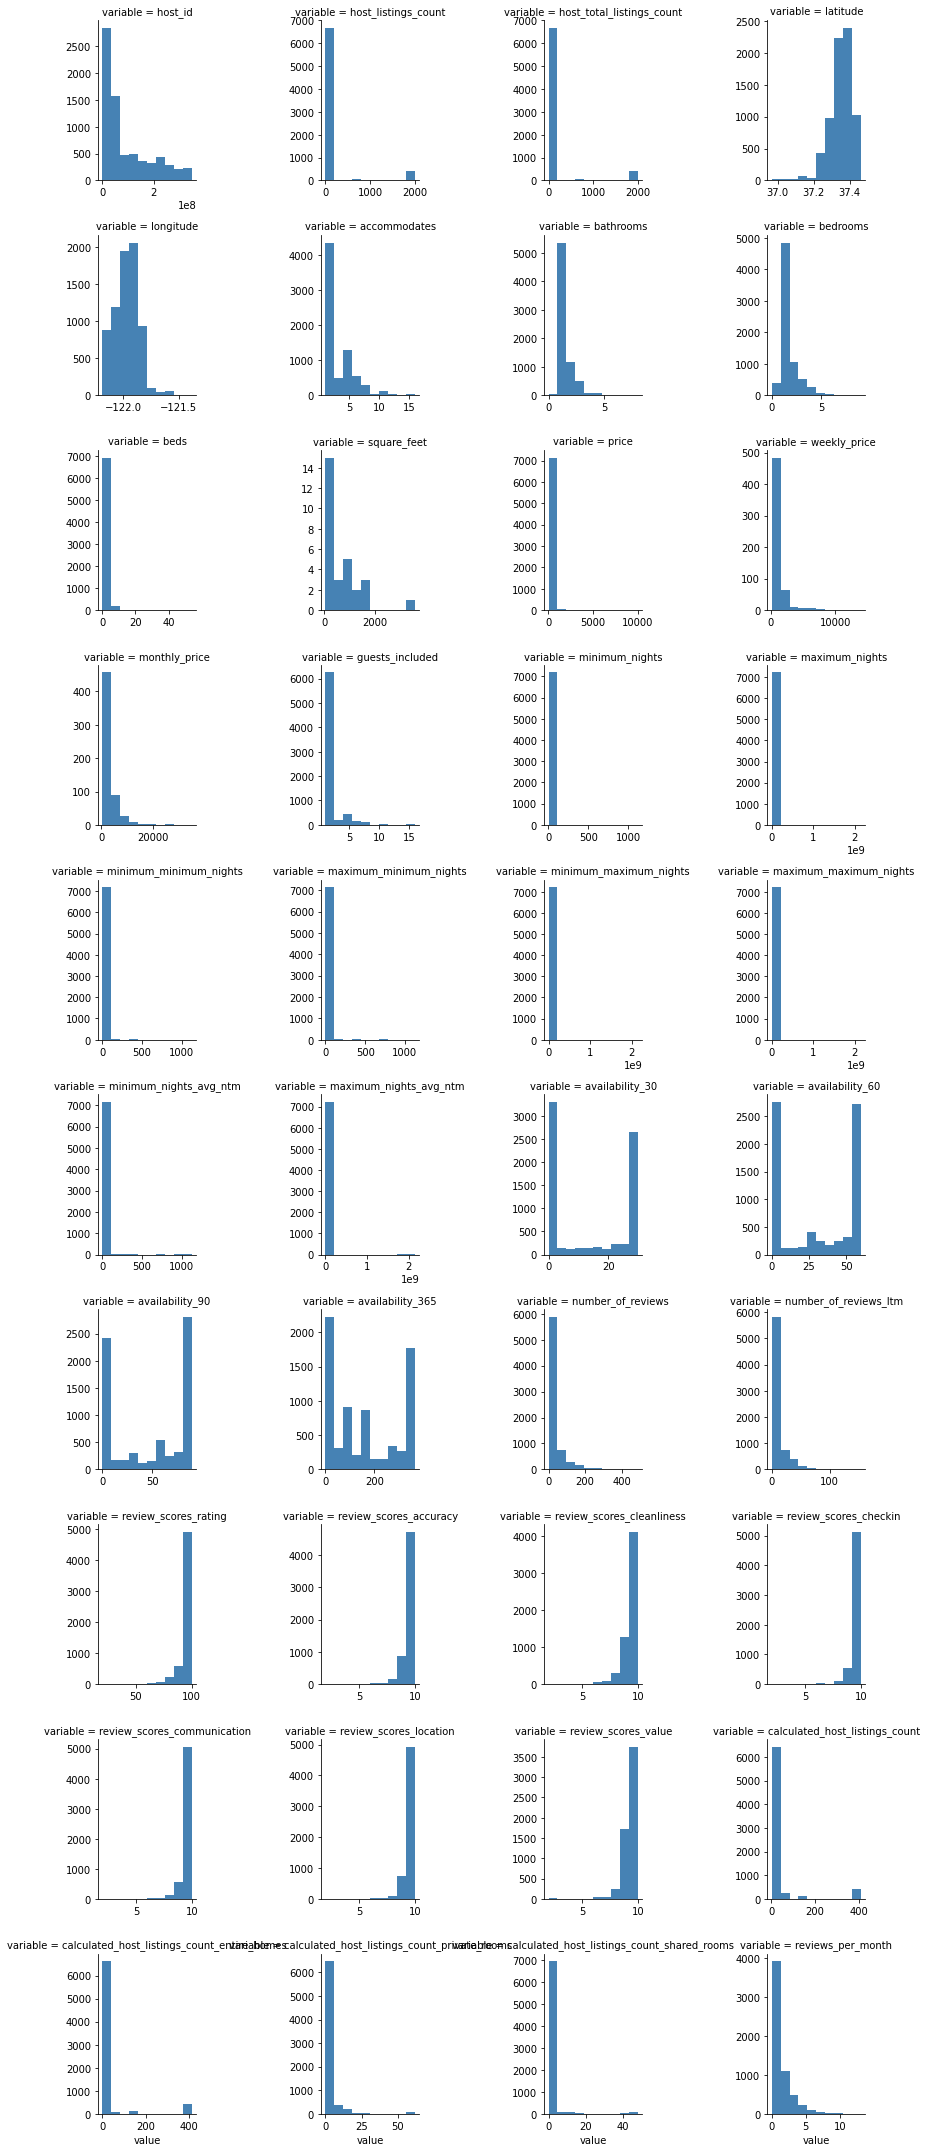

In [86]:
df = dfs_0_dropped
quan = list(df.loc[:, df.dtypes != 'object'].columns.values)
plt.figure(figsize=(30, 30))
# quan = list(df.loc[:, df.dtypes != 'object'].columns.values)
grid = sns.FacetGrid(pd.melt(df, value_vars=quan),
                     col='variable', col_wrap=4, height=3, aspect=1,
                     sharex=False, sharey=False)
grid.map(plt.hist, 'value', color="steelblue")
plt.show()

#### w/ Imputation

<Figure size 2160x2160 with 0 Axes>

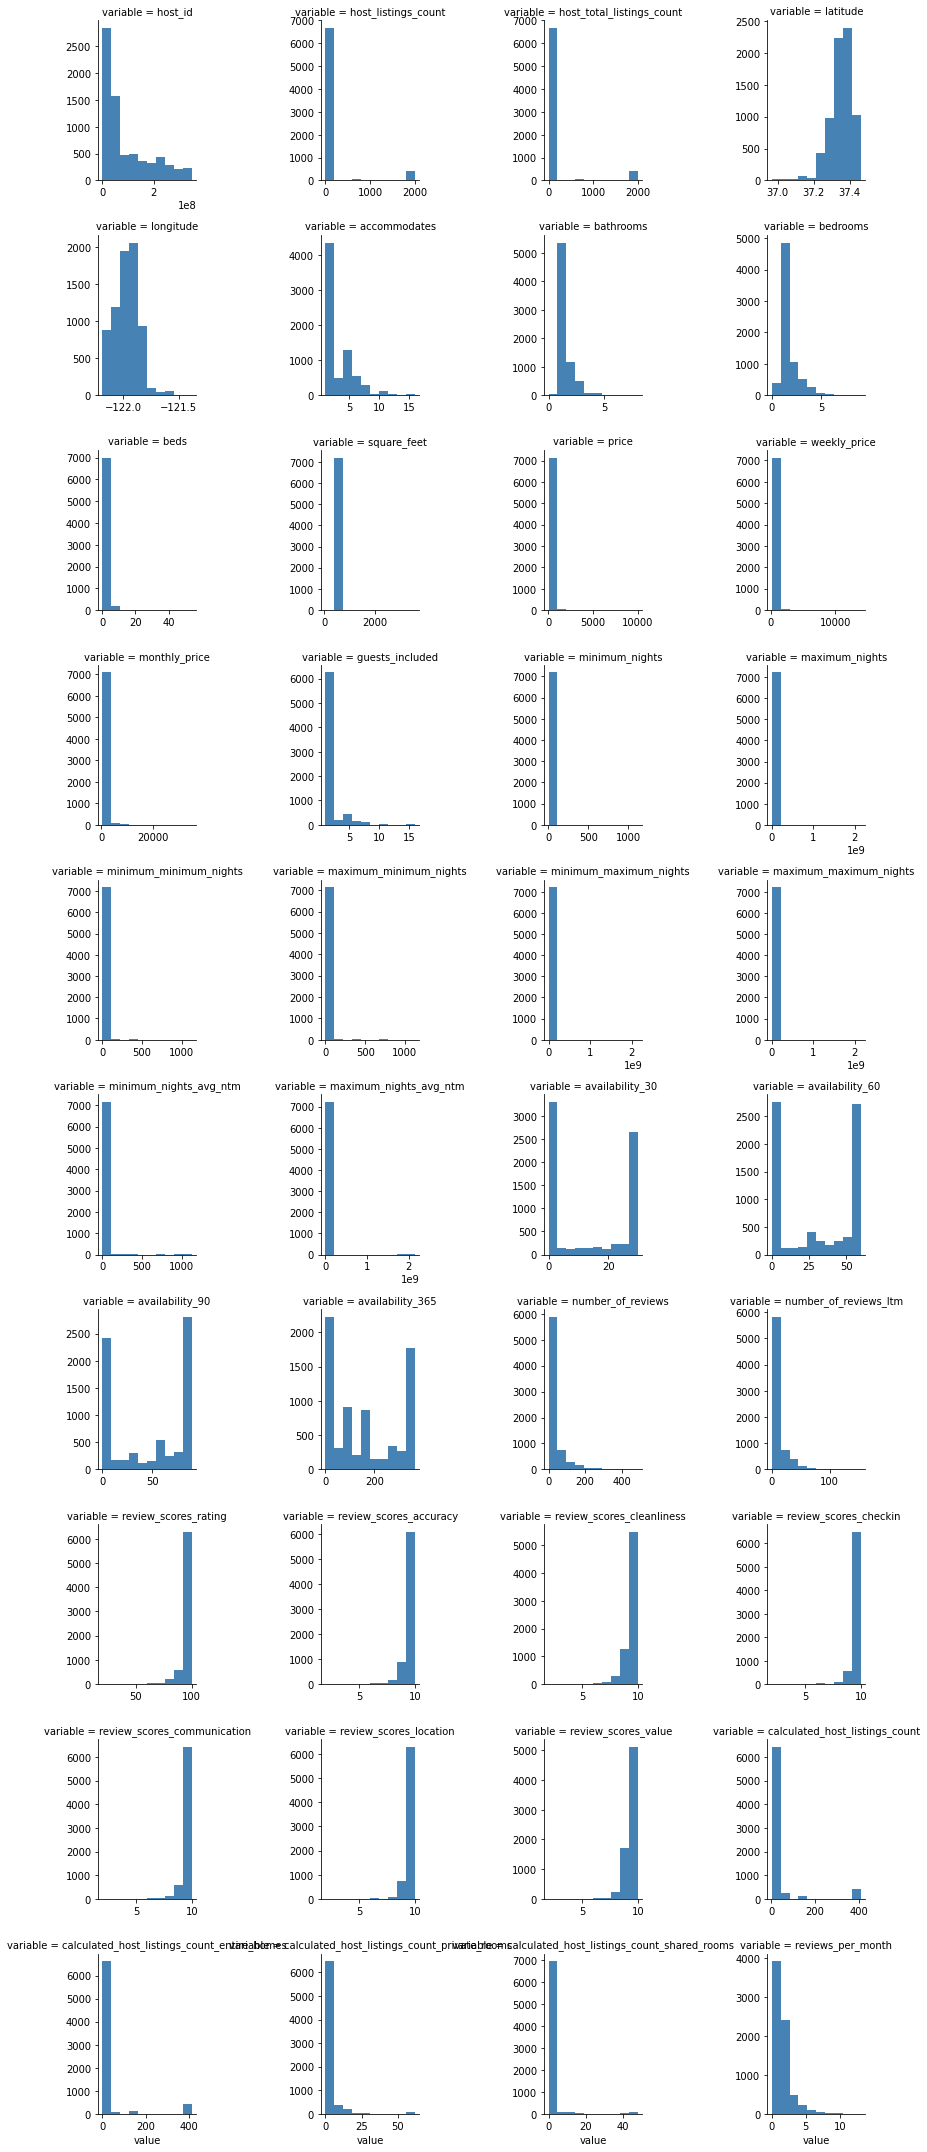

In [87]:
df = df_imputations[0]
quan = list(df.loc[:, df.dtypes != 'object'].columns.values)
plt.figure(figsize=(30, 30))
# quan = list(df.loc[:, df.dtypes != 'object'].columns.values)
grid = sns.FacetGrid(pd.melt(df, value_vars=quan),
                     col='variable', col_wrap=4, height=3, aspect=1,
                     sharex=False, sharey=False)
grid.map(plt.hist, 'value', color="steelblue")
plt.show()

###4.1.3 Y vs Per Xi (any one has Tableau?)

#### w/o Imputation

40


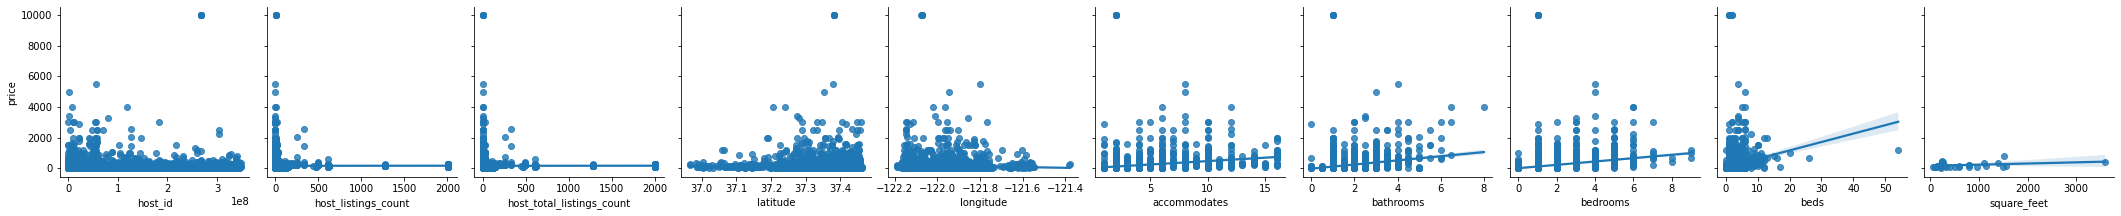

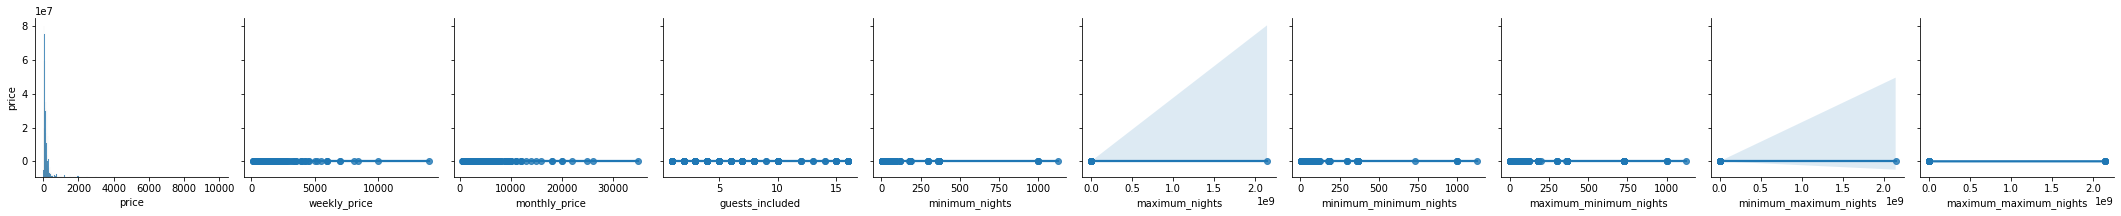

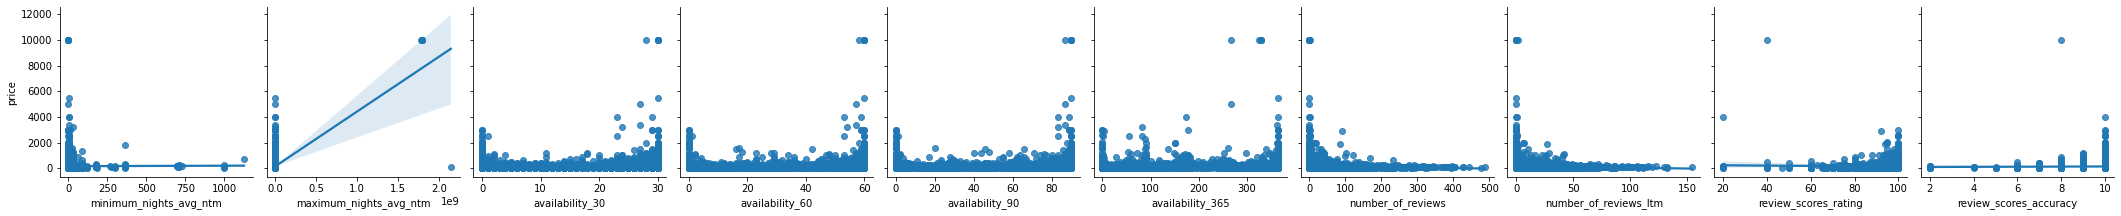

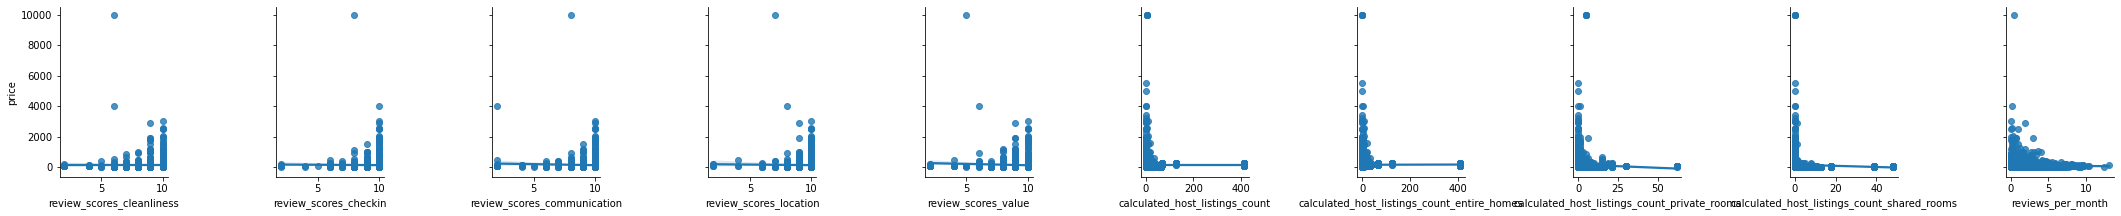

In [89]:
df = dfs_0_dropped
# Visualize correlations between dependent and numerial independent variables
print(len(quan))
start = 0
leng = 10
for i in range(len(quan) // leng):
    if not quan[start:start + leng]: 
        break
    sns.pairplot(data=df, y_vars=['price'], x_vars=quan[start:start + leng], kind='reg',
            height=3, aspect=1.0)
    start += leng
    # print(start, start + leng)
    plt.show()

#### w/ Imputation

40


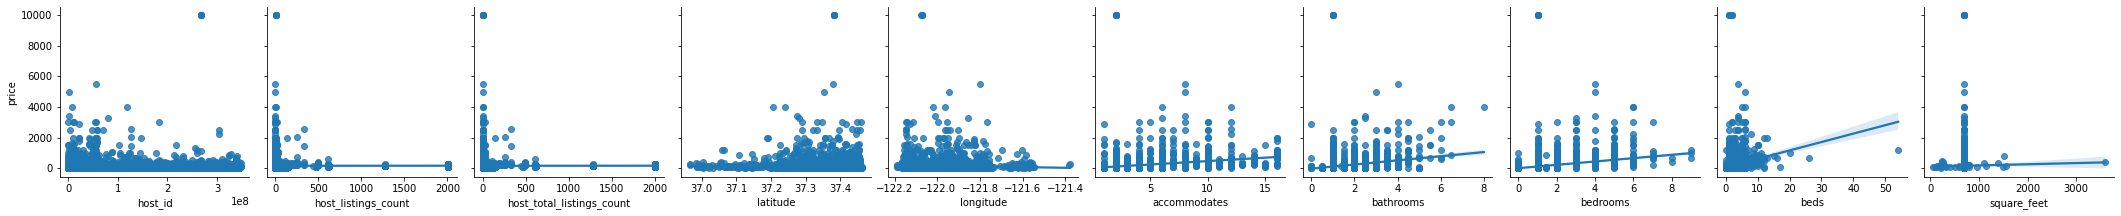

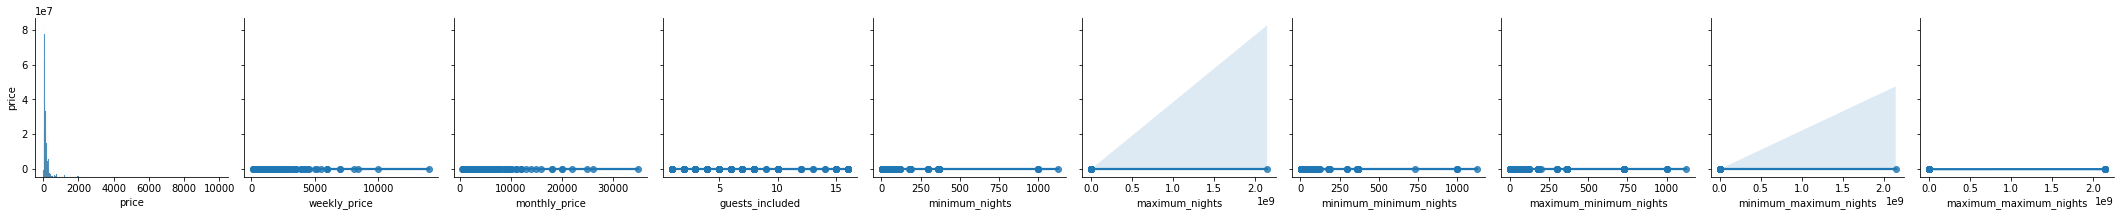

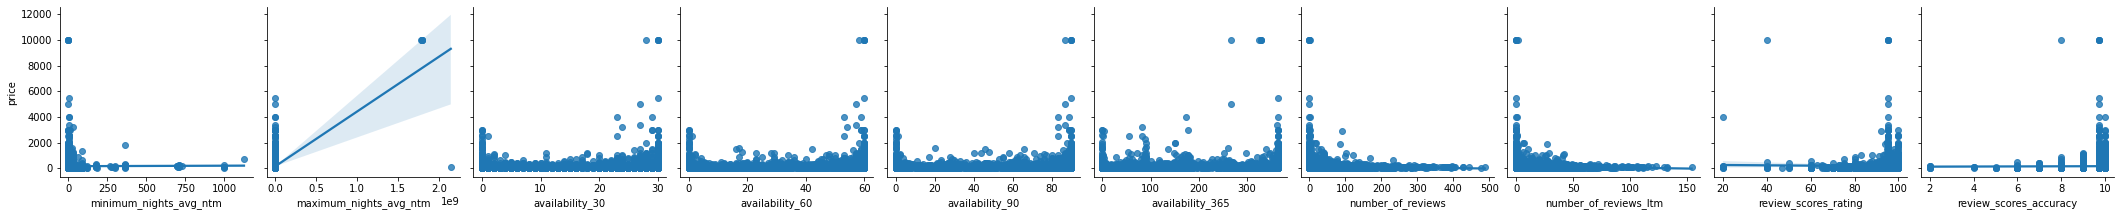

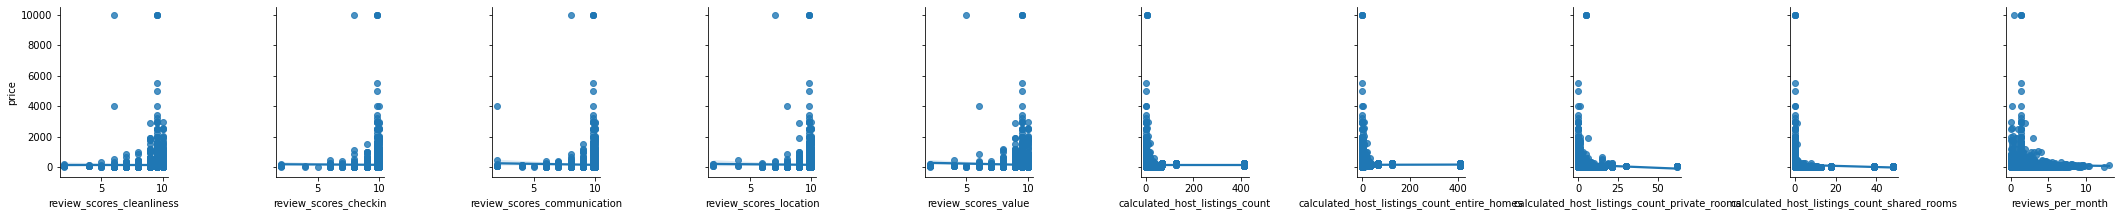

In [88]:
# Visualize correlations between dependent and numerial independent variables
print(len(quan))
start = 0
leng = 10
for i in range(len(quan) // leng):
    if not quan[start:start + leng]: 
        break
    sns.pairplot(data=df, y_vars=['price'], x_vars=quan[start:start + leng], kind='reg',
            height=3, aspect=1.0)
    start += leng
    # print(start, start + leng)
    plt.show()